In [880]:
import torch
from torch import optim
torch.manual_seed(42)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import copy

In [881]:
def draw_circle(x, y, radius, col='g'):
    # helper function to draw a circle with a given color
    th = torch.arange(0,2*np.pi,0.01)
    xunit = radius * torch.cos(th) + x
    yunit = radius * torch.sin(th) + y
    plt.plot(xunit, yunit, col)
    return xunit, yunit

In [882]:
N = 100 # number of samples/trajectories
H = 30 # horizon for each trajectory
a_dim = 2 # dimension for action space, v and w

## Sample controls from a given mean and variance

In [883]:
v_mean = torch.tensor([12]) # mean for velocity
v_var = torch.tensor([2]) # variance for velocity
w_mean = torch.tensor([0]) # mean for angular velocity
w_var = torch.tensor([2]) # variance for angular velocity

In [884]:
u = torch.randn(N,H,a_dim) # sample the controls from a normal distribution with 0 mean and 1 variance
print("Mean velocity: ",torch.mean(u[:,:,0]))
print("Mean angular-velocity: ", torch.mean(u[:,:,1]))
print("STD of Velocity: ", torch.std(u[:,:,0]))
print("STD of angular-velocity: ",torch.std(u[:,:,1]))
print("Max v: ", torch.max(u[:,:,0]))
print("Min v: ", torch.min(u[:,:,0]))
print("Max w: ", torch.max(u[:,:,1]))
print("Min w: ", torch.min(u[:,:,1]))

Mean velocity:  tensor(-0.0114)
Mean angular-velocity:  tensor(0.0272)
STD of Velocity:  tensor(1.0136)
STD of angular-velocity:  tensor(0.9986)
Max v:  tensor(2.9807)
Min v:  tensor(-3.8325)
Max w:  tensor(3.4456)
Min w:  tensor(-3.1063)


In [885]:
# update the distribution to the user-defined mean and variance
# act_seq = copy.copy(u.data)
u[:,:,0] = u[:,:,0]*v_var+v_mean
u[:,:,1] = u[:,:,1]*w_var+w_mean
print("Mean velocity: ",torch.mean(u[:,:,0]))
print("Mean angular-velocity: ", torch.mean(u[:,:,1]))
print("STD of velocity: ", torch.std(u[:,:,0]))
print("STD of angular-velocity: ",torch.std(u[:,:,1]))

Mean velocity:  tensor(11.9773)
Mean angular-velocity:  tensor(0.0543)
STD of velocity:  tensor(2.0271)
STD of angular-velocity:  tensor(1.9971)


## Clip samples within it's bounds

In [886]:
def clip(u, v_bound, w_bound):
    '''
    function to clip the velocity and angular velocity within it's bounds
    v_bound = [v_min, v_max]
    w_bound = [w_min, w_max]
    '''
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if(u[i,j,0]<v_bound[0]):
                u[i,j,0]=v_bound[0]
            if(u[i,j,0]>v_bound[1]):
                u[i,j,0]=v_bound[1]
            if(u[i,j,1]<w_bound[0]):
                u[i,j,1]=w_bound[0]
            if(u[i,j,1]>w_bound[1]):
                u[i,j,1]=w_bound[1]
    return u

In [887]:
u = clip(u, [8,20], [-0.5,0.5])
u.requires_grad = True

print("Max v: ", torch.max(u[:,:,0]))
print("Min v: ", torch.min(u[:,:,0]))
print("Max w: ", torch.max(u[:,:,1]))
print("Min w: ", torch.min(u[:,:,1]))

Max v:  tensor(17.9613, grad_fn=<MaxBackward1>)
Min v:  tensor(8., grad_fn=<MinBackward1>)
Max w:  tensor(0.5000, grad_fn=<MaxBackward1>)
Min w:  tensor(-0.5000, grad_fn=<MinBackward1>)


## Rollout the trajectories using unicycle model

In [888]:
def unicycle(state,u,dt=0.1):
    '''
    state = current state of the vehicle [x,y,theta]
    u = [v,w]
    '''
    state[2] = state[2]+u[1].float()*dt
    state[0] = state[0] + u[0]*torch.cos(state[2])*dt
    state[1] = state[1] + u[0]*torch.sin(state[2])*dt
    return state

In [889]:
start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))]) # the starting state of the vehicle
goal_state = torch.tensor([0,40,torch.deg2rad(torch.tensor([90]))]) # the goal state of the vehicle

In [890]:
def rollout(u, start_state):
    '''
    function to rollout the N trajectories using the unicycle model.
    u = sampled controls
    start_state = starting state of the vehicle
    '''
    traj_N = torch.zeros([u.shape[0],H+1,3]) # each trajectory is of size H+1 where position 0 is the current state of the vehicle
    traj_N[:,0,:]=start_state
    for i in range(u.shape[0]):
        for j in range(1,H):
            new_state = unicycle(traj_N[i,j-1,:],u[i,j,:],dt=0.1)
            traj_N[i,j,:] = new_state
    return traj_N
traj_N = rollout(u,start_state)

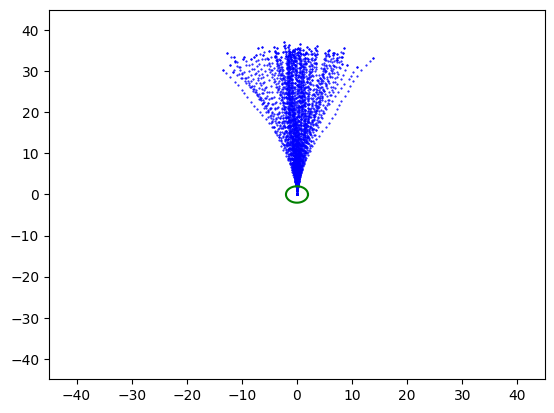

In [891]:
# plot the sampled trajectories
for i in range(N):
    plt.plot(traj_N[i,:,0].detach().numpy(),traj_N[i,:,1].detach().numpy(),'b.', ms=1)
draw_circle(0, 0, radius=2)
plt.xlim([-45,45])
plt.ylim([-45,45])
plt.show()

## Score trajectories

### Smoothness cost

In [892]:
smoothness_cost_v_N = torch.zeros(N)
smoothness_cost_w_N = torch.zeros(N)
for i in range(N):
    for j in range(1,H):
        v1 = u[i,j-1,0]
        v2 = u[i,j,0]
        w1 = u[i,j-1,1]
        w2 = u[i,j,1]
        smoothness_cost_v_N[i] += torch.linalg.norm((v2-v1))
        smoothness_cost_w_N[i] += torch.linalg.norm((w2-w1))

In [893]:
print(torch.min(smoothness_cost_w_N).data, torch.min(smoothness_cost_v_N).data )
# print(torch.min(smoothness_cost_v_N))

tensor(8.1268) tensor(43.5062)


## Select elite trajectories

In [894]:
loss = smoothness_cost_v_N + smoothness_cost_w_N

optimizer = optim.Adam([u], lr=0.01)
optimizer.zero_grad()
(smoothness_cost_v_N.mean() + smoothness_cost_w_N.mean()).backward()
for i in range(10):
    optimizer.step()
top_values, top_idx = torch.topk(loss, int(0.05*N), largest=False, sorted=True)
top_trajs = torch.index_select(traj_N, 0, top_idx)
top_controls = torch.index_select(u, 0, top_idx)

smoothness_cost_v_N = torch.zeros(int(0.05*N))
smoothness_cost_w_N = torch.zeros(int(0.05*N))
for i in range(int(0.05*N)):
    for j in range(1,H):
        v1 = top_controls[i,j-1,0]
        v2 = top_controls[i,j,0]
        w1 = top_controls[i,j-1,1]
        w2 = top_controls[i,j,1]
        smoothness_cost_v_N[i] += torch.linalg.norm((v2-v1))
        smoothness_cost_w_N[i] += torch.linalg.norm((w2-w1))
print(torch.min(smoothness_cost_w_N).data, torch.min(smoothness_cost_v_N).data)

tensor(7.6527) tensor(40.7098)


## Update the means and the variance

In [895]:
print(v_mean)
print(w_mean)
print(v_var)
print(w_var)

tensor([12])
tensor([0])
tensor([2])
tensor([2])


In [896]:
v_mean = torch.mean(top_controls[:,:,0])
v_var = torch.var(top_controls[:,:,0])
w_mean = torch.mean(top_controls[:,:,1])
w_var = torch.var(top_controls[:,:,1])

In [897]:
print(v_mean)
print(w_mean)
print(v_var)
print(w_var)

tensor(11.9768, grad_fn=<MeanBackward0>)
tensor(0.0649, grad_fn=<MeanBackward0>)
tensor(2.8616, grad_fn=<VarBackward0>)
tensor(0.1596, grad_fn=<VarBackward0>)


## Do the above steps iteratively

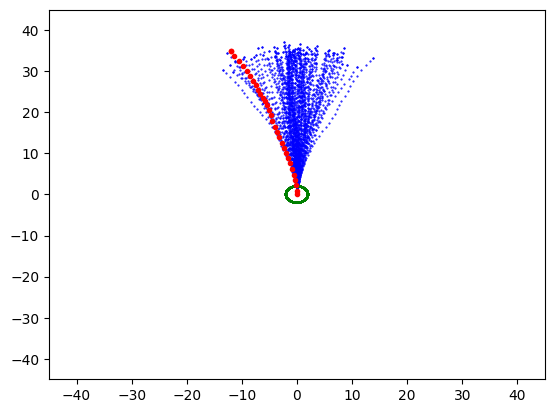

tensor(6.8026) tensor(37.6182)


<Figure size 640x480 with 0 Axes>

In [901]:
import torch
from torch import optim
torch.manual_seed(42)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import copy

v_var = 2 
w_var = 2 
v_mean = 12
w_mean = 0
for iter in range(1):
    u = torch.randn(N,H,a_dim)
    u[:,:,0] =u[:,:,0]*v_var + v_mean
    u[:,:,1] =u[:,:,1]*w_var + w_mean
    u = clip(u, [8,20], [-0.5,0.5])
    u.requires_grad = True
    start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))])
    traj_N = rollout(u,start_state)
    for i in range(N):
        line, = plt.plot(traj_N[i,:,0].detach().numpy(),traj_N[i,:,1].detach().numpy(),'b.', ms=1)
        draw_circle(0, 0, radius=2)

    smoothness_cost_v_N = torch.zeros(N)
    smoothness_cost_w_N = torch.zeros(N)
    for i in range(N):
        for j in range(1,H):
            v1 = u[i,j-1,0]
            v2 = u[i,j,0]
            w1 = u[i,j-1,1]
            w2 = u[i,j,1]
            smoothness_cost_v_N[i] += torch.linalg.norm((v2-v1))
            smoothness_cost_w_N[i] += torch.linalg.norm((w2-w1))

    loss = smoothness_cost_v_N + smoothness_cost_w_N
    optimizer = optim.Adam([u], lr=0.01)
    optimizer.zero_grad()
    (1*smoothness_cost_v_N.mean() + 1*smoothness_cost_w_N.mean()).backward()
    for i in range(20):
        optimizer.step()
    top_values, top_idx = torch.topk(loss, int(0.05*N), largest=False, sorted=True)
    top_controls = torch.index_select(u, 0, top_idx)
    top_trajs = rollout(top_controls,start_state)
    
    # total_cost_N = smoothness_cost_v_N + smoothness_cost_w_N
    # top_values, top_idx = torch.topk(total_cost_N, int(0.05*N), largest=False, sorted=True)
    # top_trajs = torch.index_select(traj_N, 0, top_idx)
    # top_controls = torch.index_select(u, 0, top_idx)
    plt.plot(top_trajs[0,:,0].detach().numpy(),top_trajs[0,:,1].detach().numpy(),'.r')
    plt.xlim([-45,45])
    plt.ylim([-45,45])
    plt.draw()
    plt.pause(1/60)
    plt.clf() 
    v_mean = torch.mean(top_controls[:,:,0].detach())
    v_var = torch.var(top_controls[:,:,0].detach())
    w_mean = torch.mean(top_controls[:,:,1].detach())
    w_var = torch.var(top_controls[:,:,1].detach())

smoothness_cost_v_N = torch.zeros(top_controls.shape[0])
smoothness_cost_w_N = torch.zeros(top_controls.shape[0])
for i in range(top_controls.shape[0]):
    for j in range(1,H):
        v1 = top_controls[i,j-1,0]
        v2 = top_controls[i,j,0]
        w1 = top_controls[i,j-1,1]
        w2 = top_controls[i,j,1]
        smoothness_cost_v_N[i] += torch.linalg.norm((v2-v1))
        smoothness_cost_w_N[i] += torch.linalg.norm((w2-w1))
print(torch.min(smoothness_cost_w_N).data, torch.min(smoothness_cost_v_N).data)

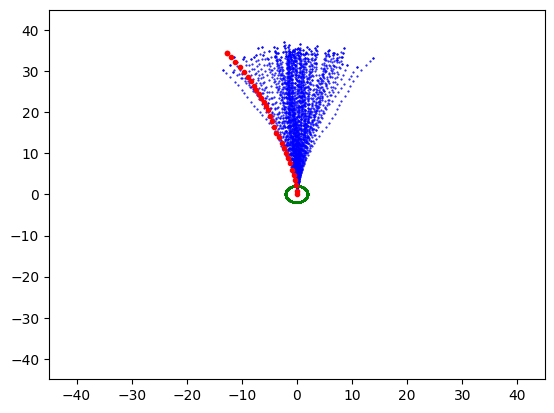

tensor(9.3267) tensor(43.5062)


<Figure size 640x480 with 0 Axes>

In [900]:
import torch
from torch import optim
torch.manual_seed(42)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import copy

v_var = 2 
w_var = 2 
v_mean = 12
w_mean = 0
for iter in range(1):
    u = torch.randn(N,H,a_dim)
    u[:,:,0] =u[:,:,0]*v_var + v_mean
    u[:,:,1] =u[:,:,1]*w_var + w_mean
    u = clip(u, [8,20], [-0.5,0.5])
    u.requires_grad = True
    start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))])
    traj_N = rollout(u,start_state)
    for i in range(N):
        line, = plt.plot(traj_N[i,:,0].detach().numpy(),traj_N[i,:,1].detach().numpy(),'b.', ms=1)
        draw_circle(0, 0, radius=2)

    smoothness_cost_v_N = torch.zeros(N)
    smoothness_cost_w_N = torch.zeros(N)
    for i in range(N):
        for j in range(1,H):
            v1 = u[i,j-1,0]
            v2 = u[i,j,0]
            w1 = u[i,j-1,1]
            w2 = u[i,j,1]
            smoothness_cost_v_N[i] += torch.linalg.norm((v2-v1))
            smoothness_cost_w_N[i] += torch.linalg.norm((w2-w1))

    loss = smoothness_cost_v_N + smoothness_cost_w_N
    # optimizer = optim.Adam([u], lr=0.01)
    # optimizer.zero_grad()
    # (1*smoothness_cost_v_N.mean() + 1*smoothness_cost_w_N.mean()).backward()
    # for i in range(20):
    #     optimizer.step()
    # top_values, top_idx = torch.topk(loss, int(0.05*N), largest=False, sorted=True)
    # top_controls = torch.index_select(u, 0, top_idx)
    # top_trajs = rollout(top_controls,start_state)
    
    total_cost_N = smoothness_cost_v_N + smoothness_cost_w_N
    top_values, top_idx = torch.topk(total_cost_N, int(0.05*N), largest=False, sorted=True)
    top_trajs = torch.index_select(traj_N, 0, top_idx)
    top_controls = torch.index_select(u, 0, top_idx)
    plt.plot(top_trajs[0,:,0].detach().numpy(),top_trajs[0,:,1].detach().numpy(),'.r')
    plt.xlim([-45,45])
    plt.ylim([-45,45])
    plt.draw()
    plt.pause(1/60)
    plt.clf() 
    v_mean = torch.mean(top_controls[:,:,0].detach())
    v_var = torch.var(top_controls[:,:,0].detach())
    w_mean = torch.mean(top_controls[:,:,1].detach())
    w_var = torch.var(top_controls[:,:,1].detach())
smoothness_cost_v_N = torch.zeros(top_controls.shape[0])
smoothness_cost_w_N = torch.zeros(top_controls.shape[0])
for i in range(top_controls.shape[0]):
    for j in range(1,H):
        v1 = top_controls[i,j-1,0]
        v2 = top_controls[i,j,0]
        w1 = top_controls[i,j-1,1]
        w2 = top_controls[i,j,1]
        smoothness_cost_v_N[i] += torch.linalg.norm((v2-v1))
        smoothness_cost_w_N[i] += torch.linalg.norm((w2-w1))
print(torch.min(smoothness_cost_w_N).data, torch.min(smoothness_cost_v_N).data)